In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
import cv2
import math
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch.nn.functional as F
from tqdm import tqdm

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
directories = []

In [4]:
image_dict = {}

In [5]:
for _, dirs, _ in os.walk("Image"):
    directories = dirs

In [6]:
file_image = os.path.join("/kaggle/input/flood-area-segmentation/", "Image")
file_masks = os.path.join("/kaggle/input/flood-area-segmentation/", "Mask")

In [7]:
file_image, file_masks

('/kaggle/input/flood-area-segmentation/Image',
 '/kaggle/input/flood-area-segmentation/Mask')

In [8]:
file_name = os.listdir(file_image)[0]
file_name

'2008.jpg'

In [9]:
full_path_image = os.path.join(file_image, file_name)
full_path_image

'/kaggle/input/flood-area-segmentation/Image/2008.jpg'

In [10]:
image = cv2.imread(full_path_image)

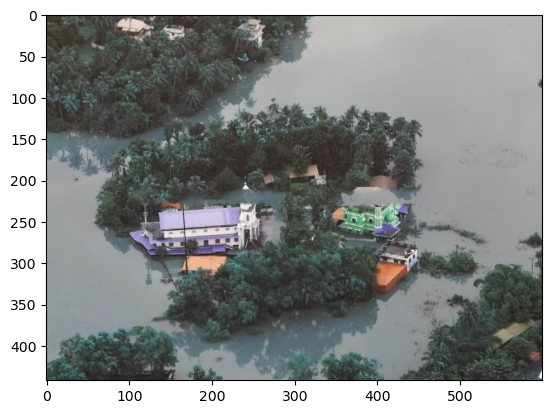

In [11]:
plt.imshow(image)
plt.show()

In [12]:
file_names = os.listdir(file_image)

In [13]:
class ImagePairDataset(Dataset):
    def __init__(self, transform, transform2):
        self.image_dict = {}
        self.transform = transform
        self.transform2 = transform2
        
        for image_name in file_names:
            full_path_image = os.path.join(file_image, image_name)
            mask_name = image_name.split(".")[0]
            full_path_mask = os.path.join("/kaggle/input/flood-area-segmentation", "Mask", mask_name + ".png")
            mask = cv2.imread(full_path_mask)

            if full_path_image not in self.image_dict:
                self.image_dict[full_path_image] = mask
            else:
                continue
    
    def __len__(self):
        return len(self.image_dict)

    def __getitem__(self, index):
        key = list(self.image_dict.keys())[index]
        image_key = cv2.imread(key)
        image = self.transform(Image.open((key)))

        
        mask = self.transform2(Image.fromarray(self.image_dict[key]))
        image, mask = image.to(device), mask.to(device)
        
        return image, mask

In [14]:
transform = transforms.Compose([
    transforms.Resize((250, 250)),
    transforms.ToTensor(),
    transforms.Grayscale(num_output_channels=1)
])

transform2 = transforms.Compose([
    transforms.Resize((52,52)),
    transforms.ToTensor(),
    transforms.Grayscale(num_output_channels=1)
])

In [15]:
dataset = ImagePairDataset(transform, transform2)

In [16]:
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

In [17]:
image, mask = next(iter(dataloader))
image.shape, mask.shape

(torch.Size([1, 1, 250, 250]), torch.Size([1, 1, 52, 52]))

In [18]:
image, mask = image.squeeze(0), mask.squeeze(0)
image.shape, mask.shape

(torch.Size([1, 250, 250]), torch.Size([1, 52, 52]))

In [19]:
numpy_array = mask.permute(1, 2, 0).cpu().numpy()
numpy_array.shape

(52, 52, 1)

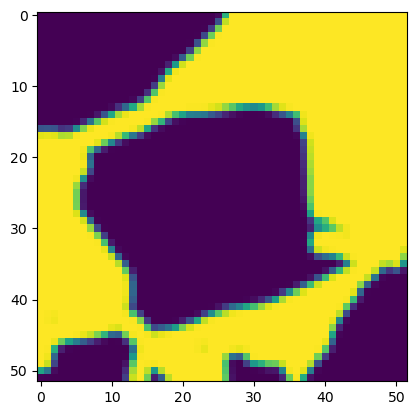

In [20]:
plt.imshow(numpy_array)

In [21]:
class Conv_block(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.layer = nn.Sequential(
            nn.Conv2d(in_features, out_features, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Conv2d(out_features, out_features, kernel_size=3, stride=1),
            nn.ReLU())
    
    def forward(self, x):
        return self.layer(x)

In [22]:
class Unet(nn.Module):
    def __init__(self):
        super().__init__()
        self.channels = [1,64,128,256,512,1024]
        self.reversed_channels = self.channels[::-1]
        self.reversed_channels = self.reversed_channels[:-1]
        
        self.module_list_enc = nn.ModuleList().to(device)
        self.module_list_dec = nn.ModuleList().to(device)
        self.concatenate_tensors = []
        
    def encoder(self):
        for index, channel in enumerate(self.channels[:-1]):
            if channel == 512:
                out_channels = self.channels[-1]
            else:
                out_channels = self.channels[index+1]
                
            
            if channel == 1:
                conv_block = Conv_block(1, out_channels)
            else:
                conv_block = Conv_block(channel, out_channels)
            
            self.module_list_enc.append(conv_block.to(device))
            if out_channels == 1024:
                continue
            self.module_list_enc.append(nn.MaxPool2d(kernel_size=(2,2)).to(device))
        
    def decoder(self):
        for index, channel in enumerate(self.reversed_channels):
            if channel == 64:
                out_channel = self.reversed_channels[index]
            else:
                out_channel = self.reversed_channels[index+1]
                
            up = nn.ConvTranspose2d(channel, out_channel, kernel_size=2, stride=2)
            conv_block = Conv_block(out_channel, out_channel)
            self.module_list_dec.append(up.to(device))
            self.module_list_dec.append(conv_block.to(device))
            
    
    def forward(self, x):
        for index, layer in enumerate(self.module_list_enc):
            if index % 2 == 0:
                x = layer(x)
            else:
                x = layer(x)
            self.concatenate_tensors.append(x.to(device)) 
        
        
        
        for index, layer in enumerate(self.module_list_dec):
            if index == len(self.module_list_dec) - 2:
                break
            if index % 2 == 0:
                x = layer(x)
                crop_tensor = self.concatenate_tensors[-index-3]
                crop_tensor = crop_tensor[:, :x.shape[1], :x.shape[2]]
            else:
                x = layer(x)
        
        last_conv = nn.Conv2d(64, 1, kernel_size=1).to(device)
        
        x = last_conv(x)
        
        return x

In [23]:
unet = Unet().to(device)

In [24]:
unet.encoder()
unet.decoder()

In [25]:
enc_output = unet(torch.randn((1,250,250)).to(device))
enc_output.shape

torch.Size([1, 52, 52])

In [26]:
enc_output = enc_output.squeeze(0)
enc_output.shape

torch.Size([52, 52])

In [27]:
enc_output_np = enc_output.detach().cpu().numpy()

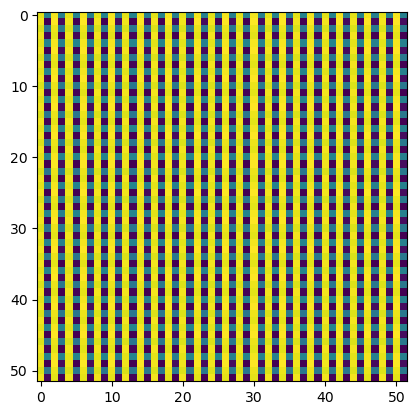

In [28]:
plt.imshow(enc_output_np)
plt.show()

In [29]:
loss = nn.CrossEntropyLoss()

In [30]:
epochs = 200
lr = 1e-2
optimizer = torch.optim.Adam(unet.parameters(), lr=lr, weight_decay=0.99)

In [31]:
#unet.to(device);
loss.to(device);

In [32]:
def train():
    iteration = []
    train_loss = []
    
    unet.train()
    
    for index, batch in enumerate(tqdm(dataloader)):
        image, mask = batch
        image, mask = image.squeeze(0), mask.squeeze(0)
        
        output = unet(image)
        
        loss_local = loss(output, mask)
        
        
        optimizer.zero_grad()
        loss_local.backward()
        optimizer.step()
        
        iteration.append(index)
        train_loss.append(loss_local.item())
        if index > 260:
            break
        
        if index % 95 == 0:
            print(f"train_loss: {loss_local}, iteration: {index}")
            print(mask.shape)
            image_to_plot = output.permute(1,2,0)
            plt.imshow(image_to_plot.detach().cpu().numpy())
            plt.show()
            print(np.max(image_to_plot.detach().cpu().numpy()), np.min(image_to_plot.detach().cpu().numpy()))

  0%|          | 0/290 [00:00<?, ?it/s]

train_loss: 103.19284057617188, iteration: 0
torch.Size([1, 52, 52])


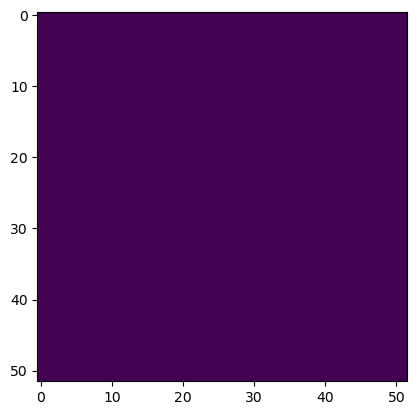

  1%|▏         | 4/290 [00:00<00:25, 11.06it/s]

-0.0155744245 -0.0155744245


 33%|███▎      | 95/290 [00:08<00:13, 14.09it/s]

train_loss: 136.816162109375, iteration: 95
torch.Size([1, 52, 52])


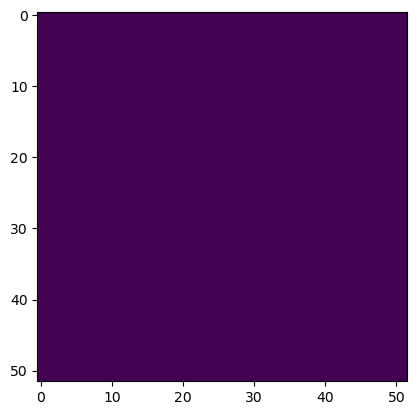

 33%|███▎      | 97/290 [00:09<00:18, 10.49it/s]

-0.11133604 -0.11133604


 60%|██████    | 174/290 [00:15<00:10, 11.51it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 15.90 GiB total capacity; 14.74 GiB already allocated; 5.75 MiB free; 14.99 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [34]:
train()